In [45]:
import glob
import os
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

from pycocotools import mask as mask_utils

import json
import numpy as np
from tqdm import tqdm

%cd cis680-team-main
# new_height, new_width  = 160, 256
new_height, new_width  = 256, 256
input_transforms = transforms.Compose([
    transforms.Resize((new_height, new_width), antialias=True),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((new_height, new_width), antialias=True),
])

def resize_bbox(bbox, original_width, original_height, new_width=256, new_height=160):
    """
    Resize bounding box coordinates based on the new image dimensions.

    Args:
        bbox (list or tuple): The original bounding box [x, y, width, height].
        original_width (int or float): The original width of the image.
        original_height (int or float): The original height of the image.
        new_width (int or float): The new width to resize the image to.
        new_height (int or float): The new height to resize the image to.

    Returns:
        list: The resized bounding box [new_x, new_y, new_width, new_height].
    """
    # Calculate scaling factors for width and height
    scale_x = new_width / original_width
    scale_y = new_height / original_height

    # Unpack the original bounding box
    x, y, w, h = bbox

    # Apply scaling factors to each component of the bounding box
    new_x = x * scale_x
    new_y = y * scale_y
    new_w = w * scale_x
    new_h = h * scale_y

    return [new_x, new_y, new_w + new_x, new_h + new_y]



class SA1B_Dataset(torchvision.datasets.ImageFolder):
    """A data loader for the SA-1B Dataset from "Segment Anything" (SAM)
    This class inherits from :class:`~torchvision.datasets.ImageFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.imgs[index] # discard automatic subfolder labels
        image = self.loader(path)
        masks = json.load(open(f'{path[:-3]}json'))['annotations'] # load json masks
        # print(json.load(open(f'{path[:-3]}json')))
        seg = []
        bbox = []

        for m in masks:
            # decode masks from COCO RLE format
            seg_piece = mask_utils.decode(m['segmentation'])
            original_height, original_width = seg_piece.shape
            seg.append(seg_piece)
            bbox.append(resize_bbox(m['bbox'], original_width, original_height, new_width=new_width, new_height=new_height))
            
        seg = np.stack(seg, axis=-1)
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            seg = self.target_transform(seg)
        seg[seg > 0] = 1 # convert to binary masks

        return image, torch.as_tensor(bbox), torch.as_tensor(seg).long()
        

    def __len__(self):
        return len(self.imgs)


input_reverse_transforms = transforms.Compose([
    transforms.ToPILImage(),
])

import matplotlib.pyplot as plt
def show_image(image, bbox, masks, num_rows=12, num_cols=12):
    # image: numpy image
    # target: mask [N, H, W]
    # fig, axs = plt.subplots(row, col, figsize=(20, 12))
    # for i in range(row):
    #     for j in range(col):
    #         if i*row+j < target.shape[0]:
    #             axs[i, j].imshow(image)
    #             axs[i, j].imshow(target[i*row+j], alpha=0.5)
    #         else:
    #             axs[i, j].imshow(image)
    #         axs[i, j].axis('off')

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))
    total = num_rows * num_cols
    
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            ax = axs[i, j]
            if idx < masks.shape[0]:
                ax.imshow(image)
                ax.imshow(masks[idx], alpha=0.5, cmap='jet')  # Use a colormap for better visibility
                # Draw bounding box
                box = bbox[idx].numpy()
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            else:
                ax.imshow(image)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


from finetune_v2 import *
import random
from torch.utils.data import Subset

path = './sa1b'
dataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
image, bbox, masks = dataset.__getitem__(3535)

# Set a manual seed for reproducibility
torch.manual_seed(42)

#subset_ratio = 0.3
#subset_size = int(subset_ratio * len(dataset))
torch.manual_seed(42)
#subset_indices = random.sample(range(len(dataset)), subset_size)

#subset_dataset = Subset(dataset, subset_indices)

from torch.utils.data import random_split
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for each set
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")


# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

NUM_WORKERS = 15  # https://github.com/pytorch/pytorch/issues/42518
NUM_GPUS = torch.cuda.device_count()
DEVICE = 'cuda'
print(NUM_WORKERS, NUM_GPUS, DEVICE)

from types import SimpleNamespace
from pytorch_lightning.strategies import DDPStrategy

def dict_to_namespace(d):
    return SimpleNamespace(**d)

config_dict = {
    "model_type": "vit_b",
    "checkpoint_path": "sam_vit_b_01ec64.pth",
    "freeze_image_encoder": False,
    "freeze_prompt_encoder": False,
    "freeze_mask_decoder": False,
    "batch_size": 4,
    'original_img_size': 1024,
    'patch_size': 16,
    'new_img_size': (256, 256),
    "steps": 224,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "metrics_interval": 50,
    "output_dir": 'project_checkpoints/'
}

args = dict_to_namespace(config_dict)

model = SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    # original_img_size = 1024,
    patch_size = 16,
    # new_img_size = (256, 256)
)

[Errno 2] No such file or directory: 'cis680-team-main'
/root/cis680-team-main
Total samples: 11186
Training samples: 8948
Validation samples: 2238
Training dataset length: 8948
Validation dataset length: 2238
15 3 cuda


In [47]:

checkpoint_path = "project_checkpoints-v2/last.ckpt"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE)) 

In [48]:
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model.to(DEVICE)

SAMFinetuner(
  (model): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256, kernel_size=(3, 3), str

In [15]:
model.to(DEVICE)

SAMFinetuner(
  (model): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256, kernel_size=(3, 3), str

In [29]:
model.model

LoRA_sam(
  (sam): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): LoRA_qkv(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (linear_a_q): Linear(in_features=768, out_features=512, bias=False)
              (linear_b_q): Linear(in_features=512, out_features=768, bias=False)
              (linear_a_v): Linear(in_features=768, out_features=512, bias=False)
              (linear_b_v): Linear(in_features=512, out_features=768, bias=False)
            )
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features

In [19]:
val_loader = torch.utils.data.DataLoader(
            val_dataset,
            collate_fn=collate_fn,
            batch_size=4,
            num_workers=NUM_WORKERS,
            shuffle=False)

In [18]:
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            collate_fn=collate_fn,
            batch_size=4,
            num_workers=NUM_WORKERS,
            shuffle=False)

Using device: cuda
Saved image to paper_visual/original_val.png


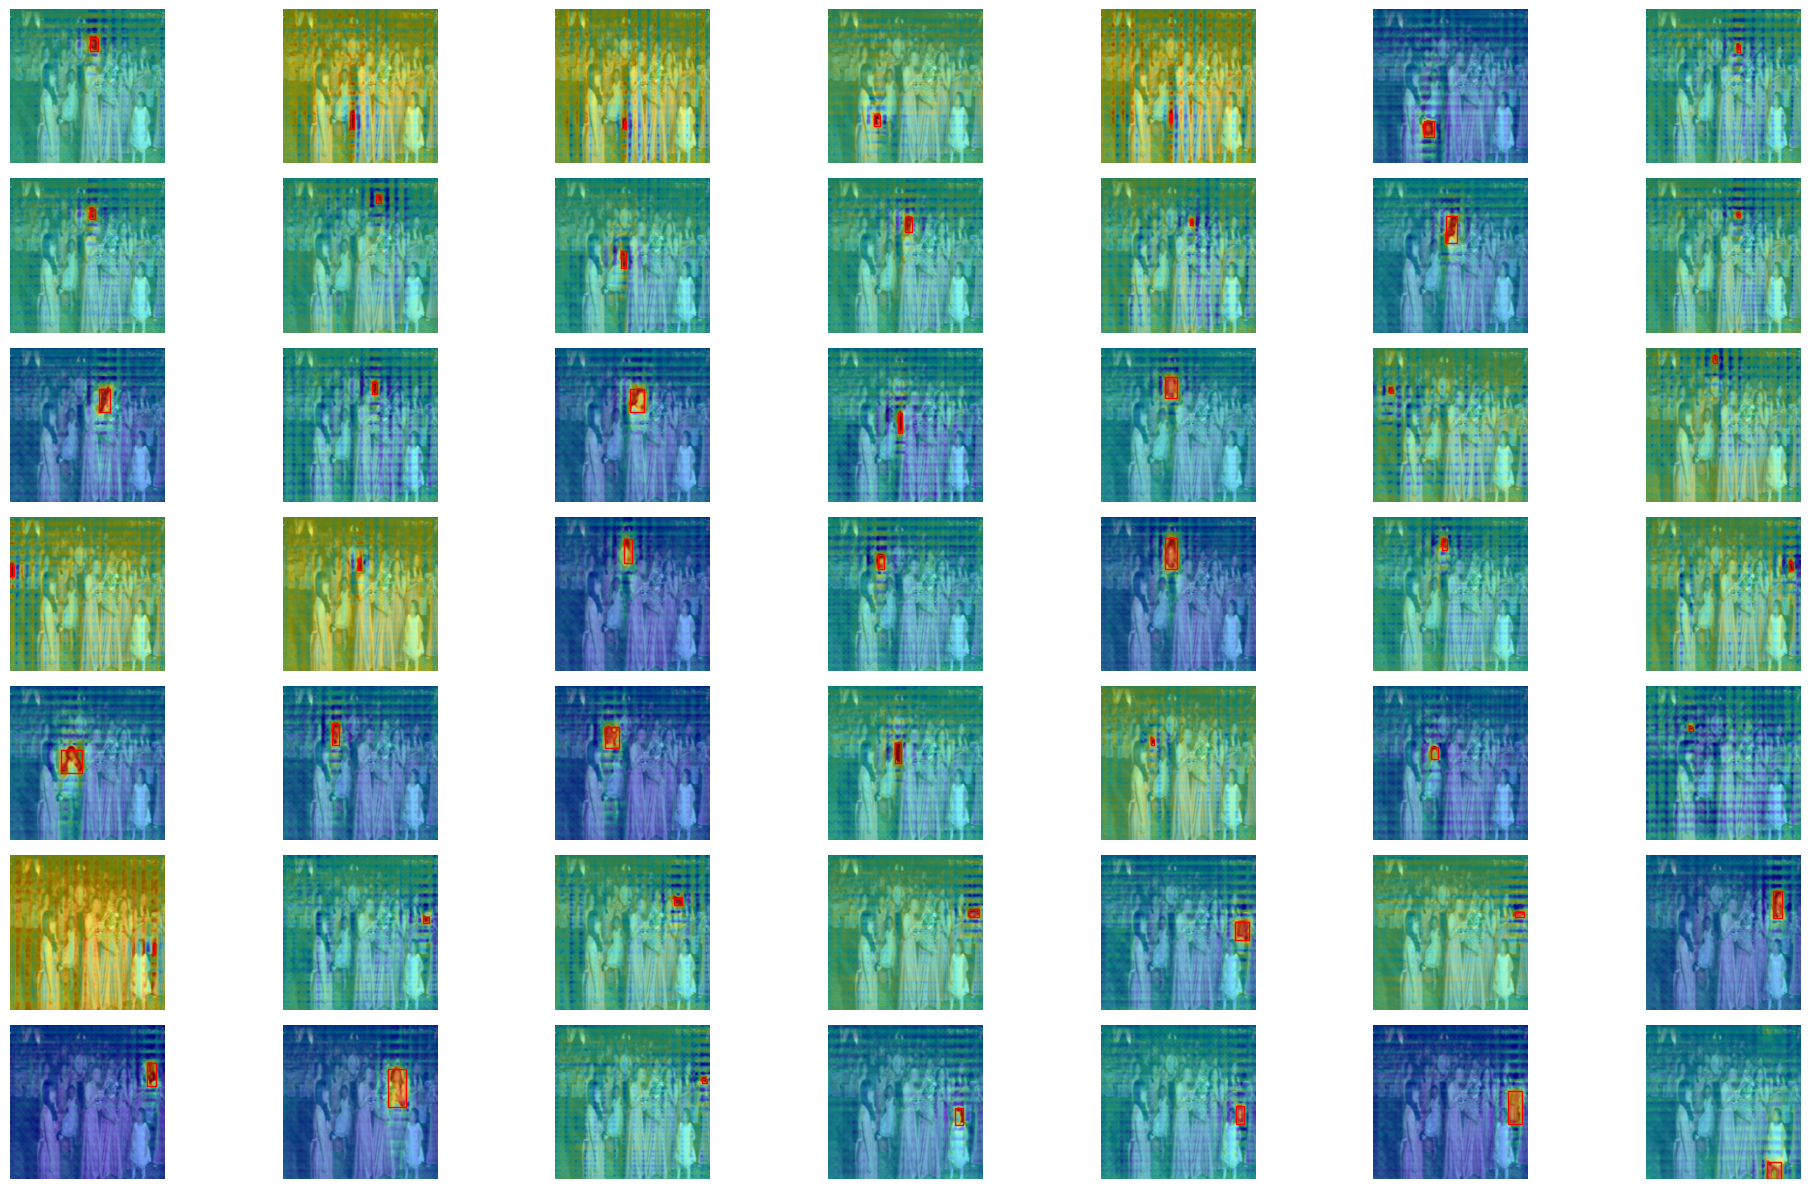

In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Assuming necessary imports from segment_anything are done
# from segment_anything import sam_model_registry

# Define your show_image function (as provided)
def show_image(image, bbox, masks, num_rows=12, num_cols=12):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))
    total = num_rows * num_cols

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            ax = axs[i, j]
            if idx < masks.shape[0]:
                ax.imshow(image)
                ax.imshow(masks[idx], alpha=1, cmap='jet')  # Use a colormap for better visibility
                # Draw bounding box
                box = bbox[idx].cpu().numpy() if isinstance(bbox[idx], torch.Tensor) else bbox[idx]
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            else:
                ax.imshow(image)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the visualization function
def show_predicted_masks(image, bbox, predicted_masks, num_rows=7, num_cols=7):
    """
    Displays the image with predicted masks and bounding boxes.

    Args:
        image (numpy.ndarray): The image array.
        bbox (Tensor or array-like): Bounding boxes for the masks.
        predicted_masks (numpy.ndarray): Predicted masks with shape [N, H, W].
        num_rows (int): Number of rows in the subplot grid.
        num_cols (int): Number of columns in the subplot grid.
    """
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))
    total = num_rows * num_cols

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            ax = axs[i, j]
            if idx < predicted_masks.shape[0]:
                ax.imshow(image)
                ax.imshow(predicted_masks[idx], alpha=0.5, cmap='jet')  # Use a colormap for better visibility
                # Draw bounding box
                box = bbox[idx].cpu().numpy() if isinstance(bbox[idx], torch.Tensor) else bbox[idx]
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            else:
                ax.imshow(image)
            ax.axis('off')
    plt.tight_layout()
    save_path = "paper_visual"
    os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist
    save_file = os.path.join(save_path, "original_val.png")
    plt.savefig(save_file, bbox_inches='tight')
    print(f"Saved image to {save_file}")
    
    plt.show()

# Function to reverse input transforms (assumed to be defined)
def input_reverse_transforms(tensor_image):
    """
    Reverse the preprocessing transformations applied to the image tensor.
    Modify this function based on your actual input_transforms.
    """
    reverse_transforms = transforms.Compose([
        transforms.ToPILImage(),
    ])
    return reverse_transforms(tensor_image)

# Function to perform inference and visualize masks
def visualize_inference(untuned_model, dataloader, device, num_images=5, num_rows=7, num_cols=7, skip_batches = 6):
    """
    Runs inference on the dataloader and visualizes the predicted masks.

    Args:
        untuned_model (SAM Model): The pre-initialized SAM model.
        dataloader (DataLoader): DataLoader for inference.
        device (str): Device to run the model on ('cuda' or 'cpu').
        num_images (int): Number of images to visualize.
        num_rows (int): Number of rows in the subplot grid.
        num_cols (int): Number of columns in the subplot grid.
    """
    untuned_model.to(device)
    untuned_model.eval()

    with torch.no_grad():
        for batch_idx, (images, bboxes, _) in enumerate(dataloader):
            images = images.to(device)  # Move images to device
            
            if batch_idx < skip_batches:
                continue

            # Assuming bboxes is a list of bounding boxes per image
            # Each bbox is expected to be in the format [x1, y1, x2, y2]

            # Prepare prompts for SAM
            # SAM expects boxes in a specific format, possibly normalized or in list of lists
            # Here, we assume boxes are in pixel coordinates and as list of tensors or lists
            # Adjust based on your SAM's expected input format

            # For each image in the batch
            for i in range(images.size(0)):
                image = images[i].cpu()
                bbox = bboxes[i]

                # Reverse transforms to get the original image
                image_pil = input_reverse_transforms(image)
                image_np = np.array(image_pil)

                # Prepare bounding boxes for SAM
                # SAM expects boxes as [x1, y1, x2, y2]
                # Ensure that bbox is in the correct format
                boxes = bbox.cpu().numpy() if isinstance(bbox, torch.Tensor) else np.array(bbox)
                boxes = boxes.astype(int).tolist()  # Convert to list of lists

                # Prepare input for SAM
                # SAM might require a list of boxes per image
                # Here, we prepare the boxes as required
                input_boxes = boxes  # List of [x1, y1, x2, y2]

                # Generate masks using SAM
                # Depending on SAM's API, you might need to call a specific method
                # For example, using sam_model.generate_masks(image, boxes)
                # Here, we assume the model has an image_encoder, prompt_encoder, and mask_decoder

                # Encode the image
                image_tensor = transforms.ToTensor()(image_pil).to(device)
                image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
                image_embedding = untuned_model.image_encoder(image_tensor)

                # Encode the prompts (boxes)
                # SAM's PromptEncoder expects boxes as a tensor
                # Convert boxes to tensor format expected by SAM
                boxes_tensor = torch.tensor(input_boxes, dtype=torch.float32).to(device)
                # SAM might expect boxes in [N, 4] where N is number of boxes
                # Adjust based on your SAM's expected input

                # Encode the prompts
                sparse_embeddings, dense_embeddings = untuned_model.prompt_encoder(
                    points=None,
                    boxes=boxes_tensor,
                    masks=None,
                )

                # Decode the masks
                low_res_masks, iou_predictions = untuned_model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=untuned_model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )

                # Upscale the masks to the original image resolution
                # Assuming image_pil.size gives (W, H)
                W, H = image_pil.size
                masks = torch.nn.functional.interpolate(
                    low_res_masks,
                    size=(H, W),
                    mode="bicubic",
                    align_corners=False,
                )

                #masks_prob = torch.sigmoid(masks)


                # Convert masks to numpy
                binary_masks_np = masks.cpu().squeeze(1).numpy()  # Shape: [num_masks, H, W]

                # Visualize the image with predicted masks
                show_predicted_masks(
                    image=image_np,
                    bbox=bbox,
                    predicted_masks=binary_masks_np,
                    num_rows=num_rows,
                    num_cols=num_cols
                )

                num_images -= 1
                if num_images <= 0:
                    return  # Stop after visualizing the desired number of images

# Example usage
if __name__ == "__main__":
    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {DEVICE}")

    # Perform visualization
    visualize_inference(
        model.model,
        dataloader=val_loader,
        device=DEVICE,
        num_images=1, 
        num_rows=7,
        num_cols=7
    )


In [4]:
from tensorboard.backend.event_processing import event_accumulator

# Path to the events file
events_file = 'lightning_logs/sam_finetuning/version_0/events.out.tfevents.1733461323.autodl-container-c4f24fa8a4-6665b147.41066.0'

# Load the event file
ea = event_accumulator.EventAccumulator(events_file)
ea.Reload()  # Load data

# List all tags (e.g., scalars, histograms, images)
print("Available Tags:", ea.Tags())

Available Tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['lr-AdamW', 'loss', 'iou', 'l_f', 'l_d', 'l_i', 'epoch', 'val_loss', 'viou', 'vl_f', 'vl_d', 'vl_i', 'val_per_mask_iou'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [5]:
scalar_data = ea.Scalars('viou')  # Replace 'tag1' with your desired scalar tag
print(scalar_data)

[ScalarEvent(wall_time=1733465076.8829803, step=49, value=0.6797575950622559), ScalarEvent(wall_time=1733468697.7818255, step=99, value=0.7184208631515503), ScalarEvent(wall_time=1733472361.645072, step=149, value=0.7449446320533752), ScalarEvent(wall_time=1733475894.116694, step=199, value=0.7597883939743042), ScalarEvent(wall_time=1733479679.9337854, step=249, value=0.7692622542381287), ScalarEvent(wall_time=1733483241.7131245, step=299, value=0.7767272591590881), ScalarEvent(wall_time=1733486839.1106074, step=349, value=0.7824459075927734)]


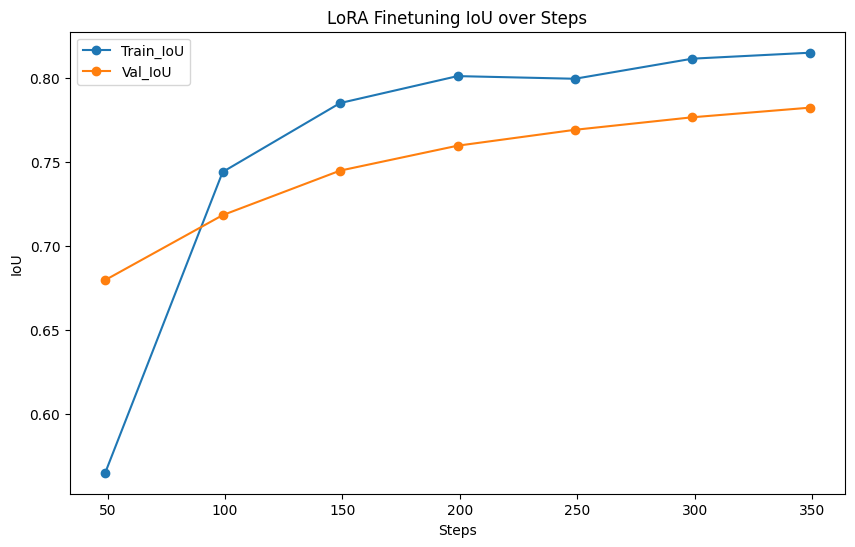

In [6]:
scalar_tags = ea.Tags().get('scalars', [])
if "iou" in scalar_tags:
    iou_events = ea.Scalars("iou")
    steps = [e.step for e in iou_events]
    values = [e.value for e in iou_events]

    val_iou_events = ea.Scalars("viou")
    steps_v = [e.step for e in val_iou_events]
    values_v = [e.value for e in val_iou_events]
    
    

    # Plot the IoU values over steps
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label='Train_IoU', marker='o')
    plt.plot(steps_v, values_v, label='Val_IoU', marker='o')
    plt.xlabel('Steps')
    plt.ylabel('IoU')
    plt.title('LoRA Finetuning IoU over Steps')
    plt.savefig('paper_visual/full_iou.png', dpi=500, bbox_inches='tight')
    plt.legend()
    plt.show()
else:
    print(f"No IoU tag found. Available tags are: {scalar_tags}")

In [58]:
""" Example 6: [LBK SAM] Batched Inputs -> **Full Grid Prompts** -> Multiple Mask Generation with filtering small and dulicated regions or holes [Very Hard] """
import numpy as np
from PIL import Image
import torch
import torchvision

from Full_Segment_Anything.mask_generator import SamMaskGenerator
import matplotlib.pyplot as plt
from Full_Segment_Anything.utils.utils import show_mask, show_points, show_lbk_masks, show_masks

from Full_Segment_Anything.build_sam import sam_model_registry
import os; os.environ["CUDA_VISIBLE_DEVICES"]="0"

# img resolution
img_resolution = 256

# prompt
from Full_Segment_Anything.utils.amg import build_all_layer_point_grids
input_point = torch.as_tensor(build_all_layer_point_grids(16, 0, 1)[0] * img_resolution, dtype=torch.int64).cuda()
input_label = torch.tensor([1 for _ in range(input_point.shape[0])]).cuda()

def prepare_image(image, img_resolution=img_resolution):
    trans = torchvision.transforms.Compose([torchvision.transforms.Resize((img_resolution, img_resolution))])
    image = torch.as_tensor(image).cuda()
    return trans(image.permute(2, 0, 1))

# image upload
img = np.array(Image.open("Full_Segment_Anything/figure/report_visual.png"))[...,:3]
img_tensor = prepare_image(img)
# plt.figure(figsize=(5,5))
# plt.imshow(img1_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(img2_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(img3_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(img4_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()

# batchify
batched_input = [
     {
         'image': x,
         'point_coords': input_point,
         'point_labels': input_label,
         'original_size': x.shape[1:]
     } for x in [img_tensor]
]

refined_masks = model.model.individual_forward(batched_input, multimask_output=True)


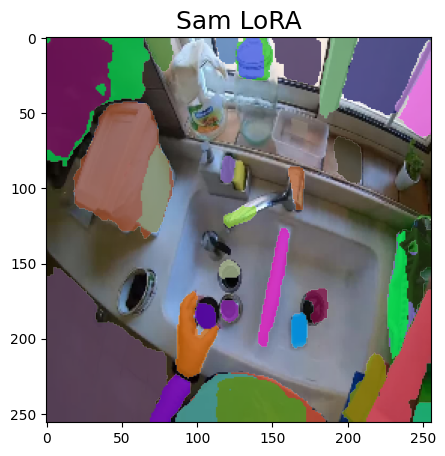

In [59]:
plt.figure(figsize=(5,5))
plt.imshow(img_tensor.permute(1,2,0).cpu().numpy())
show_lbk_masks(refined_masks[0].cpu().numpy(), plt)
# show_points(input_point.cpu().numpy(), input_label.cpu().numpy(), plt.gca())
plt.title(f"Sam LoRA", fontsize=18)
plt.savefig('paper_visual/sam_Lora.png', dpi=500, bbox_inches='tight')
plt.axis('on')
plt.show()

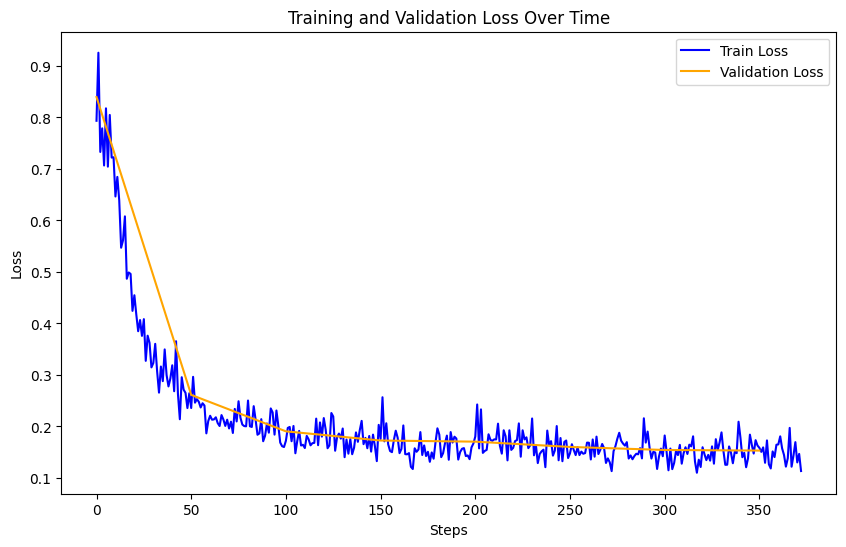

In [75]:
# Load the metrics file
data = load("training_metrics_full.pkl")

# Extract training and validation losses
train_losses = data.get('train_losses', [])
val_losses = data.get('val_losses', [])

# Create a figure
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(train_losses, label="Train Loss", color="blue")

# Plot Validation Loss (rescaled to match training steps)
if val_losses:
    plt.plot([i * 50 for i in range(len(val_losses))], val_losses, label="Validation Loss", color="orange")
else:
    plt.text(0.5, 0.5, "No validation losses found", fontsize=14, ha='center')

# Add titles and labels
plt.title("Training and Validation Loss Over Time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Save the figure
plt.savefig('paper_visual/full_train.png', dpi=500, bbox_inches='tight')
plt.show()

In [68]:
[i * 50 for i in list(range(1,8))]

[50, 100, 150, 200, 250, 300, 350]

In [72]:
len(val_losses)

8

In [31]:
from finetune_v2 import *

model = SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    # original_img_size = 1024,
    patch_size = 16,
    # new_img_size = (256, 256)
)

In [32]:
checkpoint_path = "project_checkpoints-v2/last.ckpt"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE)) 

In [33]:
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model.to(DEVICE)

SAMFinetuner(
  (model): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256, kernel_size=(3, 3), str

In [ ]:
# Example usage
if __name__ == "__main__":
    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {DEVICE}")

    # Perform visualization
    visualize_inference(
        model.model,
        dataloader=val_loader,
        device=DEVICE,
        num_images=1, 
        num_rows=7,
        num_cols=7
    )

Using device: cuda


In [41]:
""" Example 6: [LBK SAM] Batched Inputs -> **Full Grid Prompts** -> Multiple Mask Generation with filtering small and dulicated regions or holes [Very Hard] """
import numpy as np
from PIL import Image
import torch
import torchvision

from Full_Segment_Anything.mask_generator import SamMaskGenerator
import matplotlib.pyplot as plt
from Full_Segment_Anything.utils.utils import show_mask, show_points, show_lbk_masks, show_masks

from Full_Segment_Anything.build_sam import sam_model_registry
import os; os.environ["CUDA_VISIBLE_DEVICES"]="0"

# img resolution
img_resolution = 256

# prompt
from Full_Segment_Anything.utils.amg import build_all_layer_point_grids
input_point = torch.as_tensor(build_all_layer_point_grids(16, 0, 1)[0] * img_resolution, dtype=torch.int64).cuda()
input_label = torch.tensor([1 for _ in range(input_point.shape[0])]).cuda()

def prepare_image(image, img_resolution=img_resolution):
    trans = torchvision.transforms.Compose([torchvision.transforms.Resize((img_resolution, img_resolution))])
    image = torch.as_tensor(image).cuda()
    return trans(image.permute(2, 0, 1))

# image upload
img = np.array(Image.open("Full_Segment_Anything/figure/report_visual.png"))[...,:3]
img_tensor = prepare_image(img)
# plt.figure(figsize=(5,5))
# plt.imshow(img1_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(img2_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(img3_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(img4_tensor.permute(1,2,0).cpu().numpy())
# plt.axis('on')
# plt.show()

# batchify
batched_input = [
     {
         'image': x,
         'point_coords': input_point,
         'point_labels': input_label,
         'original_size': x.shape[1:]
     } for x in [img_tensor]
]

refined_masks = model.model.individual_forward(batched_input, multimask_output=True)

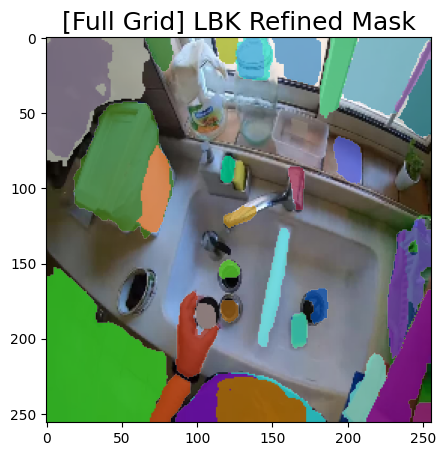

In [42]:
plt.figure(figsize=(5,5))
plt.imshow(img_tensor.permute(1,2,0).cpu().numpy())
show_lbk_masks(refined_masks[0].cpu().numpy(), plt)
# show_points(input_point.cpu().numpy(), input_label.cpu().numpy(), plt.gca())
plt.title(f"[Full Grid] LBK Refined Mask", fontsize=18)
plt.axis('on')
plt.show()

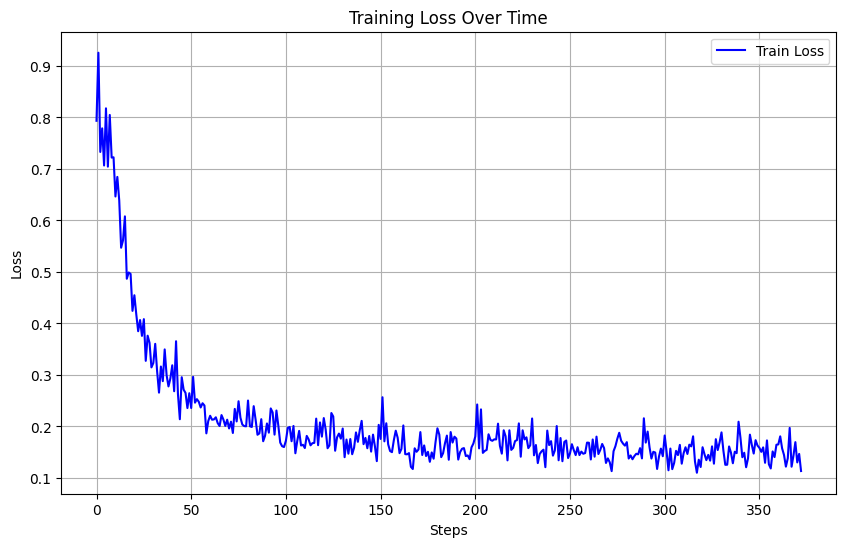

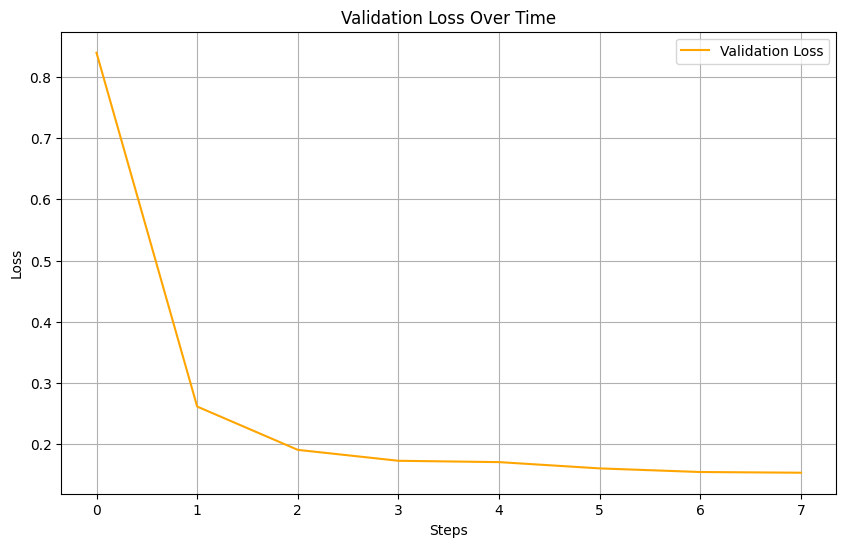

In [38]:
import matplotlib.pyplot as plt
from joblib import load

# Load the metrics file
data = load("training_metrics_full.pkl")

# Extract training and validation losses
train_losses = data.get('train_losses', [])
val_losses = data.get('val_losses', [])

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.title("Training Loss Over Time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Validation Loss
if val_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(val_losses, label="Validation Loss", color="orange")
    plt.title("Validation Loss Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No validation losses found in the file.")